## This is an analysis of residential home prices paid data from the UK, in 2018. We will also be using several approaches to predict prices paid for homes based on criteria such as home type, post-code or city, and demographic factors of the areas.

First, we will import all of the packages that we will need for our analysis.

In [1]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

%matplotlib inline

Next, we want to relabel the data so that it is more readable for our analysis. As well, we will drop a few columns that are not important for our purposes.

In [3]:
## Data does not have column headers, so we set these up to add custom column names
column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking (importing it in pieces) as it is a large file
df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

FileNotFoundError: [Errno 2] File b'/Users/user/Desktop/Datasets/pp-2018.csv' does not exist: b'/Users/user/Desktop/Datasets/pp-2018.csv'

As we are interested in only selected columns, restructure the data for these columns exclude transaction ID, secondary address (SAON), PPD category type, and record status

In [4]:
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

NameError: name 'df' is not defined

In [4]:
## We will create a couple new columns, which will help in our later analysis.
## These will be a trimmed postcode that correlates to postcode areas, as well as 
## month and year separated out from date column.

## Trim the postcode column down to the first set of characters (removing last 3)
df['postcode_area'] = [str(x)[:-4] for x in df.postcode]

## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

Now, let's take a look at what this table looks like by viewing the first few rows.

In [5]:
df.head(5)

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year
0,770000,2018-09-25,SK7 1AR,D,N,F,5,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,SK7,9,2018
1,253500,2018-09-24,M6 8GQ,D,N,F,1,RIVINGTON ROAD,NaN,SALFORD,SALFORD,GREATER MANCHESTER,M6,9,2018
2,231950,2018-09-28,WA3 2UE,D,Y,F,35,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,WA3,9,2018
3,112500,2018-08-29,OL6 6RJ,S,N,F,102,THORNFIELD GROVE,NaN,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,OL6,8,2018
4,184995,2018-06-15,M46 0TW,S,Y,F,37,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,M46,6,2018


As you can see, some of the data is not easily und3erstanbale by the reader, so we will convert the codes into more readable values.

In [6]:
prop_type_dict = {'D': 'Detached',
                 'S': 'Semi-detached',
                 'F': 'Flat',
                 'T': 'Terraced',
                 'O': 'Other'}

new_build_dict = {'N': 'Old',
                 'Y': 'New'}

duration_dict = {'F': 'Freehold',
                 'L': 'Leasehold'}

We also add a conditional to this conversion so that if this notebook is run multiple times we won't get an error.

In [16]:
if len(df['property_type'][0]) == 1:
    df['property_type'] = df['property_type'].map(prop_type_dict)

In [17]:
## comment out to prevent future errors // 
if len(df['new_build'][0]) == 1:
    df['new_build'] = df['new_build'].map(new_build_dict)

In [18]:
## comment out to prevent future errors // 
if len(df['duration'][0]) == 1:
    df['duration'] = df['duration'].map(duration_dict)

Let's take a look at the new table with converted values in the rows that we have changed...

In [20]:
df.head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year
0,770000,2018-09-25,SK7 1AR,Detached,Old,Freehold,5,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,SK7,9,2018
1,253500,2018-09-24,M6 8GQ,Detached,Old,Freehold,1,RIVINGTON ROAD,NaN,SALFORD,SALFORD,GREATER MANCHESTER,M6,9,2018
2,231950,2018-09-28,WA3 2UE,Detached,New,Freehold,35,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,WA3,9,2018
3,112500,2018-08-29,OL6 6RJ,Semi-detached,Old,Freehold,102,THORNFIELD GROVE,NaN,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,OL6,8,2018
4,184995,2018-06-15,M46 0TW,Semi-detached,New,Freehold,37,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,M46,6,2018


### Summary of key statistics

Now we are ready to pull out some insights from the dataset. We will start with some basic statistics about the whole dataset, such as average and median price paid, and total homes sold.

In [22]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)
year_select = 2018
sales_count = len(df.year == year_select)

## Key summary statistics and print out
print("Total number of homes sold in " + str(year_select) + ": " + format(sales_count, ","))
print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

Total number of homes sold in 2018: 1,023,150
Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000


Let's dive deeper into the cities themselves, specifically looking at the total homes sold by city or town. As well, we will create a method to interpret the rankings by including the option to select where in the rankings viewers would like to start and end - so that they can retrieve a list of cities for a given range.

In [24]:
## Count and sort the number of properties sold by city to create a list with a customizable range

from collections import Counter

def top_cities(start_range, end_range):
    cities_list = df.town_city

    cities_count = Counter(cities_list)
    cities_ranked = pd.DataFrame.from_dict(cities_count, orient='index').reset_index()
    cities_ranked.columns = ['City', 'Count of Sales']
    cities_ranked = cities_ranked.sort_values('Count of Sales', ascending=False).reset_index(drop=True)

    cities_top = pd.DataFrame(cities_ranked[start_range-1:end_range])
    cities_top.index += 1
    return(cities_top)
    
top_cities(100, 150)

,City,Count of Sales
100,HEREFORD,2076
101,DARTFORD,2063
102,BLACKBURN,2043
103,GREAT YARMOUTH,2038
104,KING'S LYNN,2035
...,...,...
296,WALLSEND,832
297,KENDAL,832
298,MELTON MOWBRAY,830
299,SUTTON-IN-ASHFIELD,823


Now that we have a customizable range, viewers might be interested in some more detailed information about each specific city or town - so let's create a method for them to see the median and average prices paid in any selected city or town.

In [73]:
## To look for information on any given city we create a function to return some stats on 
## any selected city. We also inlude a condition to raise errors if city is misspelled or not
## in the dataset.
def city_key_stats(city):
    if len(df[df.town_city == city.upper()]) > 0:
            avg_price_paid = round(df[df.town_city == city.upper()].price.mean(), 2)
            median_price_paid = round(df[df.town_city == city.upper()].price.median(), 2)
            print("Average 2018 price paid in " + city + " was: £" + format(avg_price_paid, ",.0f"))
            print("Median 2018 price paid in " + city + " was: £" + format(median_price_paid, ",.0f"))
    else:
        print('City or town is not in database, or was misspelled. Please try again.')

city_key_stats('Hereford')

Average 2018 price paid in Hereford was: £279,601
Average 2018 price paid in Hereford was: £226,000


We already knew that Hereford was the #100 in the UK for total homes sold, but now we can see that home prices are much lower than those in the top ten.

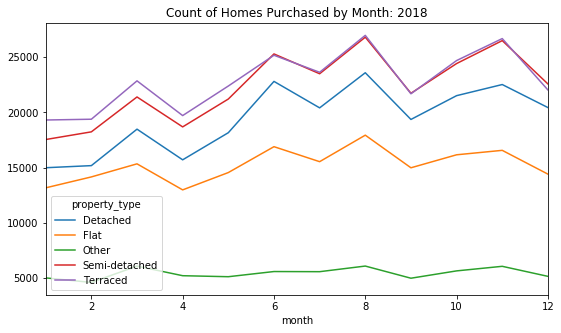

In [149]:
count_by_month = pd.pivot_table(data=df,
                               columns='property_type',
                               index='month',
                               values='price',
                               aggfunc='count',
                               observed=True)

count_by_month.plot(title='Count of Homes Purchased by Month: 2018',
                   figsize=[9,5],
                   fontsize=10)

### Viewing the dataset by selecting criteria

In [138]:
## Explore the postcodes with price range and property type
def search(price_min, price_max, prop_type):
    priceFloor = df.price > price_min
    priceCeiling = df.price < price_max
    propertyType = df.property_type == prop_type
    query = df[priceFloor & priceCeiling & propertyType].reset_index()
    df_query = pd.DataFrame(query[['price','postcode','property_type','town_city']]).sort_values('price')
    return(df_query.head(100))
          
search(350000, 400000, 'Flat')

,price,postcode,property_type,town_city
4556,350055,BS6 6XX,Flat,BRISTOL
5532,350100,SO23 7JG,Flat,WINCHESTER
2067,350100,E14 6TW,Flat,LONDON
4571,350100,GU1 3XL,Flat,GUILDFORD
6272,350100,E14 3NT,Flat,LONDON
...,...,...,...,...
809,351750,UB7 9FF,Flat,WEST DRAYTON
3579,351785,SG13 8FQ,Flat,HERTFORD
3580,351785,SG13 8FQ,Flat,HERTFORD
3573,351785,SG13 8FQ,Flat,HERTFORD


### Compare multiple cities prices paid

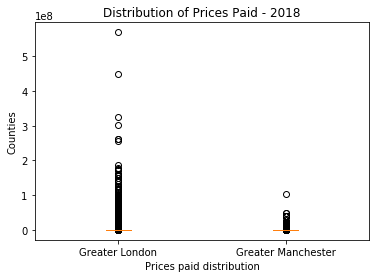

In [139]:
def county_comparison(county1, county2):
    county01 = df[df['county'] == county1.upper()]
    county02 = df[df['county'] == county2.upper()]
    
    if (len(county01) == 0) or (len(county02)) == 0:
        print('One or both of your selected counties is not available')
    
    else:    
        plt.boxplot([county01.price, county02.price],
                         labels=[county1, county2], 
                         autorange=True, widths=0.15, vert=True)
        plt.title('Distribution of Prices Paid - 2018')
        plt.xlabel('Prices paid distribution')
        plt.ylabel('Counties')
        plt.show()
    
county_comparison('Greater London', 'Greater Manchester')

In [140]:
## Add in the population density information to create a scatter plot of prices to density
## Data source: Nomis UK population database of all postcode areas and population density from
## 2011 - ONS Crown Copyright Reserved [from Nomis on 24 October 2019]
pop_density = pd.read_csv('UK_pop_density_postcodes.csv')[8:]
density_columns = ['long_code', 'postcode_area', 'population_density']
pop_density.columns = density_columns
pop_density = pop_density.drop(columns='long_code')
pop_density.head(10)

,postcode_area,population_density
8,AL10,44478.0
9,AL2,22741.0
10,AL3,28023.0
11,AL4,21890.0
12,AL5,26927.0
13,AL6,9307.0
14,AL7,39443.0
15,AL8,16375.0
16,AL9,11751.0
17,B1,20883.0


In [151]:
## Add the population density data to the prices paid dataset by merging the tables
## Used an if-statement to prevent multiple merges.
if 'population_density' not in df.columns:
    df = df.merge(pop_density, how='left', on='postcode_area')

df[df['postcode_area'] == 'N4'].head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year,population_density
18717,100000,2018-10-01,N4 2LD,Flat,Old,Leasehold,MULBERRY APARTMENTS,COSTER AVENUE,NaN,LONDON,HACKNEY,GREATER LONDON,N4,10,2018,40689.0
30346,720000,2018-10-24,N4 1JN,Terraced,Old,Freehold,9,RUTLAND GARDENS,NaN,LONDON,HARINGEY,GREATER LONDON,N4,10,2018,40689.0
30354,880000,2018-12-18,N4 1EJ,Terraced,Old,Freehold,14,VENETIA ROAD,NaN,LONDON,HARINGEY,GREATER LONDON,N4,12,2018,40689.0
30792,200000,2018-12-17,N4 3AB,Flat,Old,Leasehold,18A,CHARTERIS ROAD,NaN,LONDON,ISLINGTON,GREATER LONDON,N4,12,2018,40689.0
33759,1269100,2018-05-31,N4 3AP,Terraced,Old,Freehold,42,MARQUIS ROAD,NaN,LONDON,HARINGEY,GREATER LONDON,N4,5,2018,40689.0


In [176]:
## create a scatter plot to show possible correlations between population density and price
home_type = 'Detached'

z = df[df['property_type'] == home_type]

## Use the Bokeh package to make the chart interactive
from bokeh.models import BoxSelectTool, LassoSelectTool
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

TOOLS="pan,wheel_zoom,box_select,lasso_select,reset"

# create the scatter plot
p = figure(tools=TOOLS, plot_width=600, plot_height=600, min_border=10, min_border_left=50,
           toolbar_location="above", x_axis_location=None, y_axis_location=None,
           title="Linked Histograms")
p.background_fill_color = "#fafafa"
p.select(BoxSelectTool).select_every_mousemove = False
p.select(LassoSelectTool).select_every_mousemove = False

r = p.scatter(z.population_density, z.price, size=3, color="#3A5785", alpha=0.6)
show(r)

Loading BokehJS ...

ValueError: "Invalid object to show. The object to passed to show must be one of:

* a LayoutDOM (e.g. a Plot or Widget or Layout)
* a Bokeh Application
* a callable suitable to an application FunctionHandler


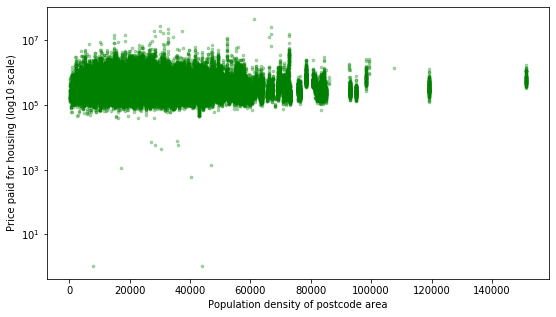

In [172]:
plt.figure(figsize=[9,5])
ax = plt.scatter(z.population_density, z.price, s=7, alpha=0.3, c='green')
ax = plt.xlabel('Population density of postcode area')
ax = plt.ylabel('Price paid for housing (log10 scale)')
# Set the y-axis to desired scale to better show the distribution of price data
ax = plt.yscale('log')
ax

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [108]:
## Create a new dataframe using the function created above to capture the 
## top 10 cities by sales counts

df_ten = df[df['town_city'].isin(top_cities(1, 10).iloc[:,0])]

In [109]:
test_df = df_ten[['property_type', 'new_build', 'town_city']]
test_df.head()

,property_type,new_build,town_city
4,Semi-detached,New,MANCHESTER
5,Detached,New,MANCHESTER
6,Detached,Old,MANCHESTER
10,Semi-detached,Old,MANCHESTER
11,Semi-detached,Old,MANCHESTER


In [11]:
enc = OneHotEncoder(sparse=False)

x_encoded = enc.fit_transform(test_df)

x_encoded = pd.DataFrame(x_encoded)

x_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183738,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183739,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183740,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183741,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
build_type = df_ten['new_build']
prop_type = df_ten['property_type']
cityID = df_ten['town_city']

xencode = LabelEncoder()
build_type = xencode.fit_transform(build_type)
xkeys = xencode.classes_
xkeys = list(xkeys)

yencode = LabelEncoder()
prop_type = yencode.fit_transform(prop_type)
ykeys = yencode.classes_
ykeys = list(ykeys)

zencode = LabelEncoder()
cityID = zencode.fit_transform(cityID)
zkeys = zencode.classes_
zkeys = list(zkeys)

cols = xkeys + ykeys + zkeys
cols

['N',
 'Y',
 'D',
 'F',
 'O',
 'S',
 'T',
 'BIRMINGHAM',
 'BRISTOL',
 'LEEDS',
 'LEICESTER',
 'LIVERPOOL',
 'LONDON',
 'MANCHESTER',
 'NOTTINGHAM',
 'SHEFFIELD',
 'SOUTHAMPTON']

In [13]:
build_type = pd.DataFrame(build_type)
prop_type = pd.DataFrame(prop_type)
cityID = pd.DataFrame(cityID)

data = pd.concat([build_type, prop_type, cityID], axis=1)
data

,0,0,0
0,1,3,6
1,1,0,6
2,0,0,6
3,0,3,6
4,0,3,6
...,...,...,...
183738,0,4,6
183739,0,1,6
183740,0,1,6
183741,0,3,6


In [14]:
data_ohe = OneHotEncoder().fit_transform(data).toarray()
z = pd.DataFrame(data_ohe)

z.columns = cols
z['price'] = df_ten.price.reset_index().price
z.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,N,Y,D,F,O,S,T,BIRMINGHAM,BRISTOL,LEEDS,LEICESTER,LIVERPOOL,LONDON,MANCHESTER,NOTTINGHAM,SHEFFIELD,SOUTHAMPTON,price
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,184995
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,214995
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,378000
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,183000
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,111000


### Assign the data to the scikit-learn packages, starting with Decision Trees

In [18]:
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import locale

locale.setlocale(locale.LC_ALL, "")

feature_cols = cols

X = z[feature_cols] #features
y = z.price #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Create Decision Tree classifer object
reg = DecisionTreeRegressor()

# Train Decision Tree Classifer
model = reg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [23]:
y_train_pred = model.predict(X_train)

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

3795216.7466940037

In [21]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

2595266.079894468

In [ ]:
rand = np.random.uniform(low=0, high=len(df_ten))

X_new = df_ten.iloc[int(rand)]

# Model Accuracy, how often is the regressor correct?
print("City X: %s" % X_new.loc['town_city'])
print('X: £{:,.2f}, Predicted: £{:,.2f}'.format(X_new[0], y_pred[X_new[0]]))
print('Difference (£): {:+,.0f}'.format(X_new[0] - y_pred[0]))
print('Difference Predicted (%): {:+.2f}%'.format(((y_pred[0] - X_new[0]) / X_new[0]) * 100))

No handles with labels found to put in legend.


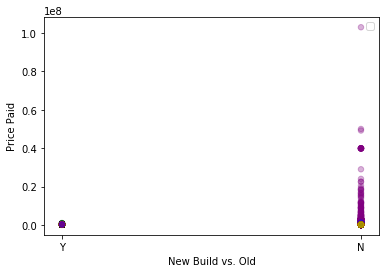

In [16]:
# City for graph
city = 'Manchester'

# number representing size
x1 = df[df['town_city'] == city.upper()].new_build

# generate array of property types
x2 = df[df['town_city'] == city.upper()].property_type

# number representing price
y = df[df['town_city'] == city.upper()].price

# create mapping from property type to matplot colour
property_type_colour_map = {'D' : 'blue', 
                            'S' : 'red', 
                            'T' : 'yellow', 
                            'F' : 'green', 
                            'O' : 'purple'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, alpha=0.3, s=30)
plt.xticks()
plt.yticks()
plt.xlabel('New Build vs. Old')
plt.ylabel('Price Paid')
plt.legend()
plt.show()

### ROUGH CELLS

### Also, we need to generalize the postcodes by removing the last 3 letters to provide a better geographical grouping (6-7 character postcodes are overly specific)

In [9]:
## Create new columns to enumerate the string data in Property Type and New Build columns
#prep_prop_type = {'D' : 1, 
#                  'S' : 2, 
#                  'T' : 3, 
#                  'F' : 4, 
#                  'O' : 5}

#prep_new_build = {'N': 0, 
#                  'Y': 1}

#df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
#df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]